## Plot the emittance growth rate vs different values of noise.
- The simulation code is ran 3 times to imporve the accuracy, with different seeds of random numbers where they appear (eg ζ at the white noise kick and the initial particle distributions. 
- The emittance growth is averaged ovr turns and the variance is estimated. 

### test that you have acces to the /afs directory where your data are stored
If permision denied
- $USERNAME@CERN.CH 
- aklog

In [1]:
ls /afs/cern.ch/work/n/natriant/private

my_tracking_model_htcondor/  simulation_data_2018/  sixdesk/  workspaces/


In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from math import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

### Plotting parameters

In [3]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 23,
          'axes.titlesize': 23,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Compute emittance

In [4]:
# #--- <x^2> ---
def mean2(numb):
    return np.mean( (numb - np.mean(numb))**2 )

# #--- <xx'> ---
def mean3(numbx , numbpx):
    return np.mean( (numbx - np.mean(numbx)) * (numbpx - np.mean(numbpx)) )

# #--- sqrt(<x^2> * <px^2> - <xx'>^2) --- compute statistical emittance
def cmp_emit(position, angle):
    return  np.sqrt(mean2(position) * mean2(angle) - mean3(position,angle)**2) # geometrical emittance

### Import the parameters of the study

In [5]:
data = {}
with open('./configuration_files/config_rate_vs_gain.json', "r") as read_file:
        data = json.load(read_file)
my_afs_path = '/afs/cern.ch/work/n/natriant/private/my_tracking_model_htcondor/tracking_data/'

### Loop over delta values and the three versions

In [6]:
Qx_list = [62.837, 62.845, 62.85]
Qx_list = [62.85]
versions = [1, 2, 3]

### Loop over studies. Dictionaries to store the emittance values over turns, 1 dictionay for each version, 1 for each value of delta

In [7]:
ex_dictionary = {}
for version in versions:
    ex_dictionary['v{}'.format(version)] = {}
    for Qx in Qx_list:
        print('version {}, Qx {}'.format(version, Qx))
        ex_dictionary['v{}'.format(version)]['Qx{}'.format(Qx)] = []
        df = pd.read_pickle(my_afs_path+'Qx{:.3f}_ksi0.030_g0.200_delta0.050_betax115.75_particles15000_turns1000_aperture100_v{}.pkl'.format(Qx, version))
        for turn in range(data['study_parameters']['turns']):
            ex_dictionary['v{}'.format(version)]['Qx{}'.format(Qx)].append(cmp_emit(df.at[turn, 'x']/sqrt(data['machine_parameters']['beta_x']), df.at[turn, 'px']*sqrt(data['machine_parameters']['beta_x'] )))

version 1, Qx 62.85
version 2, Qx 62.85
version 3, Qx 62.85


### Plot the emittance evolution for one WP for the three different runs

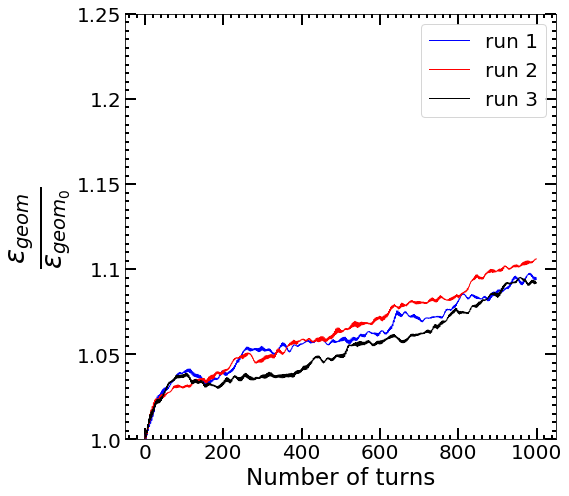

In [8]:
Qx = 62.85

fig, ax = plt.subplots()
colors = ['b', 'r', 'k']
for index, version in enumerate(versions):
    ax.plot(ex_dictionary['v{}'.format(version)]['Qx{}'.format(Qx)]/ex_dictionary['v{}'.format(version)]['Qx{}'.format(Qx)][0], c = colors[index], label = 'run {}'.format(version))
    
ax.set_xlabel('Number of turns')    
ax.set_ylabel(r'$\frac{\epsilon_{geom}}{\epsilon_{geom_0}}$', fontsize =40)

# Set the ticks in both sides of the axes
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# Display minor ticks on the axis
ax.minorticks_on() 
# Set the limits of the axis
ax.set_ylim(1, 1.25)

# Set the appearance of the ticks
ax.tick_params(which='both',direction='in', width=2)
ax.tick_params(which='major',direction='in', length=11)
ax.tick_params(which='minor',direction='in', length=4)

ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(0.005))

# Set the current tick locations and labels of the x and y-axis.
y_ticks_list = [1.0, 1.05, 1.1, 1.15, 1.2, 1.25]
y_labels = [str(i) for i in y_ticks_list]
plt.yticks(y_ticks_list, y_labels)
x_ticks_list = [0, 200, 400, 600, 800, 1000]
x_labels = [str(i) for i in x_ticks_list]
plt.xticks(x_ticks_list, x_labels)


# Make axis equal. Note that the size of the figure affects this
ax.set_aspect(aspect='auto')
    
plt.legend()
plt.tight_layout()
save_flag = False
if save_flag:
    plt.savefig('./figures/emittance_vs_3runs_Qx{:.3f}_si0.030_g0.200_delta0.050_betax115.75_particles15000_turns1000_aperture100_1000turns.png'.format(Qx))

### Estimate and plot the averaged emittance over the three runs and estimate the variance (standard error)

The standard error $\sigma_x$ between the three different runs (versions) is calculated by: 
\begin{equation}
\sigma_x = \frac{\sigma}{\sqrt{n}}
\end{equation}
, where $\sigma$ is the standard deviation of the population and $n$ the number of observations of the sample

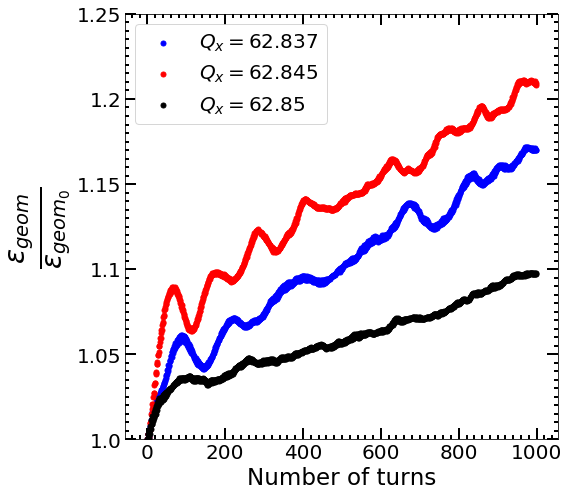

In [25]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

fig, ax = plt.subplots()
turns_list = np.arange(0, data['study_parameters']['turns'])
colors = ['b','r','k']
error_bars = False

for index, Qx in enumerate(Qx_list):
    for turn in turns_list:
        ex_current_list = [] # list with the emittance values for the three different runs 
        ex_initial = 0
        for version in versions:
            # Normalise with the initial values of the geometric emittance
            ex = ex_dictionary['v{}'.format(version)]['Qx{}'.format(Qx)][turn]/ex_dictionary['v{}'.format(version)]['Qx{}'.format(Qx)][0]
            # Append the values to the list
            ex_current_list.append(ex)
        # Calculate average and variance
        average_ex = np.mean(ex_current_list)
        standard_error = np.std(ex_current_list)/sqrt(len(versions))
        
        if error_bars :
            if turn == 0:
                ax.errorbar(turn, average_ex, yerr=standard_error, c=colors[index], marker ='o', ms =4, label =r'$Q_x={}$'.format(Qx))
            else:
                ax.errorbar(turn, average_ex, yerr=standard_error, c=colors[index], marker ='o', ms =4)
        else:
            if turn == 0:
                ax.scatter(turn, average_ex, c=colors[index], label =r'$Q_x={}$'.format(Qx))
            else:
                ax.scatter(turn, average_ex,  c=colors[index])
        
ax.set_xlabel('Number of turns')    
ax.set_ylabel(r'$\frac{\epsilon_{geom}}{\epsilon_{geom_0}}$', fontsize =40)

# Set the ticks in both sides of the axes
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# Display minor ticks on the axis
ax.minorticks_on() 
# Set the limits of the axis
ax.set_ylim(1, 1.25)

# Set the appearance of the ticks
ax.tick_params(which='both',direction='in', width=2)
ax.tick_params(which='major',direction='in', length=11)
ax.tick_params(which='minor',direction='in', length=4)

ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(0.005))

# Set the current tick locations and labels of the x and y-axis.
y_ticks_list = [1.0, 1.05, 1.1, 1.15, 1.2, 1.25]
y_labels = [str(i) for i in y_ticks_list]
plt.yticks(y_ticks_list, y_labels)
x_ticks_list = [0, 200, 400, 600, 800, 1000]
x_labels = [str(i) for i in x_ticks_list]
plt.xticks(x_ticks_list, x_labels)


# Make axis equal. Note that the size of the figure affects this
ax.set_aspect(aspect='auto')

plt.legend()
plt.tight_layout()
save_flag = False
if save_flag:
    plt.savefig('./figures/emittance_vs_tunes_QxScan_si0.030_g0.200_delta0.050_betax115.75_particles15000_turns1000_aperture100_Noerror_bars_1000turns.png')


### Lebedev's format
Use the same format as Lebedev in his studies at the second paper (simulations)

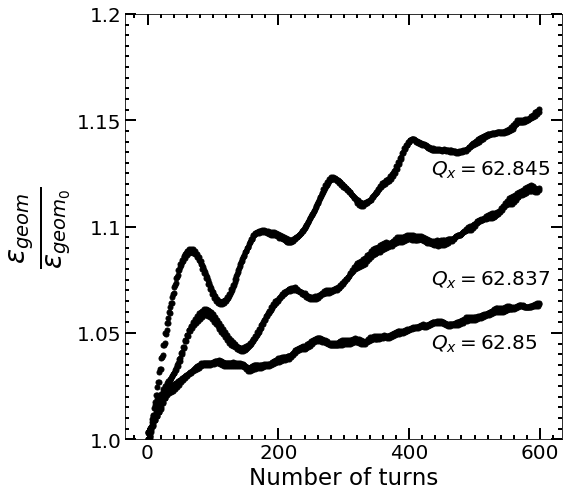

In [17]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

fig, ax = plt.subplots()
turns_list = np.arange(0, data['study_parameters']['turns'])

error_bars = False

for index, Qx in enumerate(Qx_list):
    for turn in turns_list[0:600]:
        ex_current_list = [] # list with the emittance values for the three different runs 
        ex_initial = 0
        for version in versions:
            # Normalise with the initial values of the geometric emittance
            ex = ex_dictionary['v{}'.format(version)]['Qx{}'.format(Qx)][turn]/ex_dictionary['v{}'.format(version)]['Qx{}'.format(Qx)][0]
            # Append the values to the list
            ex_current_list.append(ex)
        # Calculate average and variance
        average_ex = np.mean(ex_current_list)
        standard_error = np.std(ex_current_list)/sqrt(len(versions))
        
        if error_bars :
            ax.errorbar(turn, average_ex, yerr=standard_error, c='k', marker ='o', ms =4)
        else:
            if turn == 0:
                ax.scatter(turn, average_ex, c='k', label = Qx)
            else:
                ax.scatter(turn, average_ex, c='k')
        
ax.set_xlabel('Number of turns')    
ax.set_ylabel(r'$\frac{\epsilon_{geom}}{\epsilon_{geom_0}}$', fontsize =40)

# Set the ticks in both sides of the axes
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# Display minor ticks on the axis
ax.minorticks_on() 
# Set the limits of the axis
ax.set_ylim(1, 1.2)

# Set the appearance of the ticks
ax.tick_params(which='both',direction='in', width=2)
ax.tick_params(which='major',direction='in', length=11)
ax.tick_params(which='minor',direction='in', length=4)

ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(0.005))

# Set the current tick locations and labels of the x and y-axis.
y_ticks_list = [1.0, 1.05, 1.1, 1.15, 1.2]
y_labels = [str(i) for i in y_ticks_list]
plt.yticks(y_ticks_list, y_labels)
x_ticks_list = [0, 200, 400, 600]
x_labels = [str(i) for i in x_ticks_list]
plt.xticks(x_ticks_list, x_labels)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', alpha=0)
#place a text box in upper left in axes coords
ax.text(0.7, 0.66, r'$Q_x=62.845$', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props) 
ax.text(0.7, 0.4, r'$Q_x=62.837$', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
ax.text(0.7, 0.25, r'$Q_x=62.85$', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

# Make axis equal. Note that the size of the figure affects this

ax.set_aspect(aspect='auto')
plt.tight_layout()
save_flag = False
if save_flag:
    plt.savefig('./figures/emittance_vs_tunes_QxScan_si0.030_g0.200_delta0.050_betax115.75_particles15000_turns1000_aperture100_Noerror_bars_Lebedev_format.png')
